## Load packages

In [1]:
# Useful packages
import os
import warnings

# Work with Python array and graphs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Cluster tendency
from pyclustertend import hopkins

# Mapping
from sklearn.metrics import pairwise_distances, accuracy_score
from coclust.evaluation.external import accuracy
from skbio.stats.ordination import pcoa
from multiview.mvmds import mvmds

# Clustering algorithm
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
#from KMedoidsPaper import KMedoids

# Clustering performance evaluation
from sklearn.metrics import davies_bouldin_score, silhouette_score

//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [2]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

scikit-learn==0.22.1
numpy==1.17.0
matplotlib==3.2.1


## Load data

In [3]:
def loadShapedMatrix(mat,studiedPeriodsFile,studiedClassesFile):
    # Load data from CSV
    nameEnd = ("%s" %studiedClassesFile).replace("[", "")
    if ('%s.csv' %(nameEnd))[0] == " ":
        nameEnd = ('%s' %(nameEnd))[1:] # remove first space if there is
    nameEnd = ("%s" %nameEnd).replace("]", "")
    nameEnd = ("%s" %nameEnd).replace(" ", "  ") # 1 space -> 2 spaces ; 2 spaces -> 4 spaces
    nameEnd = ("%s" %nameEnd).replace("    ", "   ") # 4 spaces -> 3 spaces
    nameStart = ("%s" %studiedPeriodsFile).replace("[", "")
    nameStart = ("%s" %nameStart).replace("]", "")
    nameStart = ("%s" %nameStart).replace(" ", "  ")
    
    ISC = np.genfromtxt(os.path.join('school_%s%s_%s.csv' %(mat,nameStart,nameEnd)),delimiter=',')
    ISC = np.array(ISC,dtype='float') # Convert into array

    # Initialize reshaped ISC
    nParticipants = ISC.shape[0]
    nPeriod = int(np.sqrt(ISC.shape[1] / nParticipants))
    ISC_sh = np.zeros((ISC.shape[0]*nPeriod,ISC.shape[0]*nPeriod))

    # Reshape data by moving blocks
    for period1 in range(nPeriod):
        for period2 in range(nPeriod):
            if (period1 == period2): # We must symmetrize this block containing NaNs
                subISC = np.nan_to_num(ISC[:,nParticipants*(nPeriod*period1+period2):nParticipants*(nPeriod*period1+period2+1)])
                subISC = (subISC+subISC.T)/2
            else:
                subISC = ISC[:,nParticipants*(nPeriod*period1+period2):nParticipants*(nPeriod*period1+period2+1)]
            
            ISC_sh[nParticipants*period1:nParticipants*(period1+1),nParticipants*period2:nParticipants*(period2+1)] = subISC

    # Make reshaped ISC symmetrical
    ISC_sh = np.nan_to_num(ISC_sh)
    ISC_sh = (ISC_sh+ISC_sh.T)/2 
    
    return ISC_sh,nPeriod,nParticipants


# To study : DONT USE LINSPACE OR ARANGE BUT HAND WRITTEN ARRAY, OTERHWISE WILL NOT FIND THE CSV
studiedPeriodsFile = np.array([1])
#studiedPeriodsFile = np.array([1,4])

#studiedClassesFile = np.array([1,2])
studiedClassesFile = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

# Load EDA and IBI
ISC_EDA,nPeriod,nParticipants = loadShapedMatrix('EDA',studiedPeriodsFile,studiedClassesFile)
#ISC_IBI,nPeriod,nParticipants = loadShapedMatrix('IBI',studiedPeriodsFile,studiedClassesFile)
ISC_IBI = ISC_EDA

# Remove rows with NaNs
def removeNaNSubject(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    new_mat = np.delete(new_mat, (subject), axis=1)
    
    return new_mat

# Remove participant in vector
def removeSubjectsVector(vector,subjects):
    new_vect = np.copy(vector)
    for subj in subjects:
        new_vect = np.delete(new_vect, (subj), axis=0)
    
    return new_vect

# Remove rows in ISC if NaN
def removeNaNISC(ISC):
    last_i = 0
    i = 0
    subjectsRemoved = []
    remove = False
    nbTotal = len(ISC) 
    while (last_i < nbTotal and i < nbTotal - 1):
        for i in range(nbTotal):
            remove = False
            for p in range(nPeriod):
                if ISC[p*nParticipants,i] == 0.:
                    remove = True
                    break

            if remove:        
                ISC = removeNaNSubject(ISC,i)
                last_i = i
                nbTotal -= 1
                subjectsRemoved.append(i)
                break
                
    print(subjectsRemoved)
    return ISC, subjectsRemoved

    #print(last_i)

    
    
ISC_EDA,subjectsRemoved_EDA = removeNaNISC(ISC_EDA)
ISC_IBI,subjectsRemoved_IBI = removeNaNISC(ISC_IBI)



import csv
    
with open(os.path.join('test.csv'), 'w') as File:
    writer = csv.writer(File,delimiter =',')
    writer.writerows(ISC_EDA)        
        


[17, 17, 51, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68]
[17, 17, 51, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68]


## Compute distance matrix

In [4]:
def computeDistanceMatrix(study_matrix):
    
    # Normalise maximum value to 1
    normed_matrix = np.copy(study_matrix)
    normed_matrix = normed_matrix / np.max(abs(normed_matrix))
    
    # Convert into distance matrix
    distance_matrix = np.sqrt((1-normed_matrix)) # Formula in Matlab and in Scikit to convert 
        
    # Interval MDS normalization to spread values between 0 and 1
    a = np.min(np.sort(distance_matrix,axis=0)[1,:])
    distance_matrix = distance_matrix - a
    distance_matrix = distance_matrix - np.diag(np.diag(distance_matrix))
    distance_matrix = distance_matrix / np.max(distance_matrix)
    
    # To make sure output is perfectly symmetrical
    return (distance_matrix+distance_matrix.T)/2

## Multiview mapping

In [5]:
def computeAllDistanceMatrix(ISC_EDA,ISC_IBI):
    
    # Make copy of 2 matrices (for each modality)
    mat_EDA = np.copy(ISC_EDA)
    mat_IBI = np.copy(ISC_IBI)
    
    # Compute the 2 distance matrices (according to each modality)
    distance_matrix_EDA = computeDistanceMatrix(ISC_EDA)
    distance_matrix_IBI = computeDistanceMatrix(ISC_IBI)
  
    # Remove direct correlation influence and compute correlation distance matrices
    for i in range(len(mat_EDA)):
        mat_EDA[i,i] = 0
    for i in range(len(mat_IBI)):
        mat_IBI[i,i] = 0
    distance_matrix_corr_EDA = pairwise_distances(mat_EDA,metric='correlation')
    distance_matrix_corr_IBI = pairwise_distances(mat_IBI,metric='correlation')

    # Return distance matrices
    return distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI


In [6]:
def computeCoordinate(mat=['EDA','IBI','corrEDA','corrIBI'],added=False):

    # Compute all distance matrices
    distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    
    #distance_matrix_EDA, distance_matrix_corr_EDA = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    

    # Choose which matrices to include into the multiview
    multiviewMat = []
    if ('EDA' in mat):
        multiviewMat.append(distance_matrix_EDA)
        distance_matrix = distance_matrix_EDA
    if ('IBI' in mat):
        multiviewMat.append(distance_matrix_IBI)
        distance_matrix = distance_matrix_IBI
    if ('corrEDA' in mat):
        multiviewMat.append(distance_matrix_corr_EDA)
    if ('corrIBI' in mat):
        multiviewMat.append(distance_matrix_corr_IBI)
        
    # Compute mapping
    embeddingDim = dim # to have a 2D map
    
    if len(mat)==1:
        points = np.array(pcoa(distance_matrix, method='eigh', number_of_dimensions=embeddingDim).samples)
        print("pcoa proportion explained : %s " %np.sum(pcoa(distance_matrix, method='eigh', number_of_dimensions=embeddingDim).proportion_explained))
    else:
        points = mvmds(multiviewMat,len(mat)*[True],embeddingDim,added=added)
    
    return points

In [7]:
import umap.umap_ as umap
from sklearn import preprocessing

def computeUMAPCoordinate(mat,sslLabel=None,n_neighbors=3):

    if (mat==['EDA']):
        study_matrix = ISC_EDA
    if (mat==['IBI']):
        study_matrix = ISC_IBI

    fitter = umap.UMAP(n_components=int(dim),n_neighbors=n_neighbors,metric='correlation',min_dist=0.0,init='spectral',target_weight=0.5,n_epochs=5000).fit(study_matrix,sslLabel)
    #points = preprocessing.scale(fitter.embedding_,axis=0)
    points = (fitter.embedding_ - np.mean(fitter.embedding_,axis=0)) / np.std(fitter.embedding_,axis=0)
    #print(np.std(points))
    #print(np.mean(points))
    return points

In [8]:
from sklearn.cluster import SpectralClustering

def computeSCCoordinate(mat,gamma=1):
    
    distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    
    #distance_matrix_EDA, distance_matrix_corr_EDA = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    

    if (mat==['EDA']):
        distance_matrix = distance_matrix_EDA
    if (mat==['IBI']):
        distance_matrix = distance_matrix_IBI
    
    
    clusteringDist = SpectralClustering(n_clusters=dim+1, n_init=10,affinity='precomputed')
    affinity_matrix = np.exp(-gamma * distance_matrix ** 2)
    clusteringDist.fit(affinity_matrix)
    return clusteringDist.map_[:,1:]

In [9]:
from sklearn.cluster import SpectralClustering

def computeNoneCoordinate(mat):
    
    distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    
    #distance_matrix_EDA, distance_matrix_corr_EDA = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    

    if (mat==['EDA']):
        distance_matrix = distance_matrix_EDA
    if (mat==['IBI']):
        distance_matrix = distance_matrix_IBI
    
    return distance_matrix

## Compute clustering

In [10]:
class Results():

    def __init__(self,mat,mapping,algo,condition):
        self.mat = mat
        self.mapping = mapping
        self.algo = algo
        self.condition = condition
        
    def twoClustersMethodResult(self):
        print("Blind results\n")
        
        # Cluster tendency
        print("Hopkins test")
        self.hopkinsCoef()
        print("%f +- %f" %(self.hopkins[0],self.hopkins[1]))
        
        # Found clusters
        print("Found clusters ")
        print(self.label)
        
        # Clustering quality evaluation
        print("Silhouette coefficient : %0.3f" %self.silhouetteCoef())
        print("DB index : %f " %self.dbScore())
                
        # Comparing to ground truth (if known)
        if (os.path.isfile(os.path.join('conditionSchool_EDA.csv')) and os.path.isfile(os.path.join('conditionSchool_IBI.csv'))):
            global groundTruth
            if (groundTruth):
                print("\n\nComparing to ground truth\n")
                print("Accuracy : %f " %self.accuracy())
                #print("Well participants : [%s]" % ", ".join(map(str, self.wellClassified)))        
                print("Misclassified participants : [%s]" % ", ".join(map(str, self.misClassified)))        

    def applyMethod(self,method):
        
        # Mapping
        if (mapping == 'UMAP'):
            points = computeUMAPCoordinate(self.mat)
        elif (mapping == 'MDS'):
            points = computeCoordinate(self.mat,added=False)
        elif (mapping == 'MDS_scale'):
            points = computeCoordinate(self.mat,added=True)
        elif (mapping == 'SC'):
            points = computeSCCoordinate(self.mat)
        elif (mapping == 'None'): # distance matrix based clustering algorithm
            print("dist meth")
            points = computeNoneCoordinate(self.mat)
            if (algo == 'Spectral Clustering distance'):
                points = np.exp(-method.gamma * points ** 2)
        
        # Clustering
        # if (meth.distance_matrix):
        if (algo == 'K-Medoids'):
            meth = method.fit(pairwise_distances(points))
        else:
            meth = method.fit(points)

        # Store found labels and points location
        if hasattr(meth, 'labels_'):
            label = meth.labels_
        else:
            label = meth.predict(points)
            
        self.label = label
        self.best_points = points
         
    def showResultMap(self):
        
        # Set new figure
        plt.figure()
        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        
        # Annotate points
        if mat == ['EDA']:
            n = len(ISC_EDA)
        elif mat == ['IBI']:
            n = len(ISC_IBI)        
        for i in range(n):
            ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+(np.max(self.best_points[:,0])-np.min(self.best_points[:,0]))/50,self.best_points[i,1]))     
    
        # Show color according to trueDisplay bool
        global trueDisplay
        if (trueDisplay):
            # Scatter points
            for i in range(n_clusters):
                ax.scatter(self.best_points[self.trueGroups[i],0],self.best_points[self.trueGroups[i],1],s=145,label=str(i))
            
            # Add legend
            TP = mpatches.Patch(color='blue', label='NA')
            TN = mpatches.Patch(color='red', label='SSA')
            FP_FN = mpatches.Patch(color='black', label='misclassified')
            #plt.legend(handles=[TP,TN,FP_FN])
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            #plt.axis('off')
            #axes = plt.gca()
            #axes.set_xlim([-0.4,0.4])
            #axes.set_ylim([-0.4,0.7])
            plt.savefig(os.path.join('figures','GT_%s.png' %self.mat),bbox_inches='tight')
        else:
            # Scatter points
            for i in range(n_clusters):
                ax.scatter(self.best_points[self.label == i,0],self.best_points[self.label == i,1],s=145,label=str(i))
            
            # Add legend
            group0 = mpatches.Patch(color='darkgreen', label='First group')
            group1 = mpatches.Patch(color='darkorange', label='Second group')
            #plt.legend(handles=[group0,group1])       
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            #plt.axis('off')
            plt.savefig(os.path.join('figures','clustering_%s.png' %self.mat),bbox_inches='tight')

        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EDA):
            warnings.warn("Each participant correspond to one label")
            return -1
        elif len(np.unique(self.label))==len(ISC_IBI):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return davies_bouldin_score(self.best_points,self.label)
        
    def hopkinsCoef(self):
        # Average on different random data generated in Hopkins
        H = []
        if mat == ['EDA']:
            n = len(ISC_EDA)
        elif mat == ['IBI']:
            n = len(ISC_IBI)
        for p in range(100):
            H.append(hopkins(self.best_points,n)) 
        self.hopkins = [1-np.mean(H),np.std(H)]
        
        # Raise a warning if Hopkins test <= 0.5
        if (self.hopkins[0]<=0.5):
            warnings.warn("Hopkins test <= 0.5 : data set does not have clustering tendency")
            
    def silhouetteCoef(self):
        # Compute Silhouette Coefficient based on distance matrix (the closer it is to 1, the better the clustering is)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EDA):
            warnings.warn("Each participant correspond to one label")
            return -1
        elif len(np.unique(self.label))==len(ISC_IBI):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return silhouette_score(self.best_points, self.label, metric='euclidean')
        
    def accuracy(self):
        self.trueGroups = []
        for i in range(n_clusters):
            self.trueGroups.append(np.where(self.condition == i)[0])
        
        # Find which participants are misclassified and compute accuracy
        if mat == ['EDA']:
            subjects = np.arange(len(ISC_EDA))
        elif mat == ['IBI']:
            subjects = np.arange(len(ISC_IBI))
        self.wellClassified = subjects[self.label==condition]
        self.misClassified = subjects[self.label!=self.condition]
        '''if (len(self.misClassified) > len(self.wellClassified)):
            self.wellClassified, self.misClassified = self.misClassified, self.wellClassified
        
        return len(self.wellClassified) / len(ISC_EDA)
        '''
        print(len(ISC_IBI))
        print(self.condition)
        print(self.label)
        return accuracy(self.condition,self.label)

In [11]:
# Choose which matrix or matrices to study
mat = ['EDA']
#mat = ['EDA','IBI']

# Decide if compare to ground truth
groundTruth = True

# Display found clusters or true clusters with misclassified participants in black
trueDisplay = True

# Choose mapping method
#mapping = 'UMAP'
#mapping = 'MDS'
#mapping = 'MDS_scale'
mapping = 'SC'
#mapping = 'None'

# Choose clustering algorithm
algo = 'K-Means'
#algo = 'Spectral Clustering'
#algo = 'Hierarchical Clustering'
#algo = 'K-Medoids'

#algo = 'Spectral Clustering distance'
#algo = 'Hierarchical Clustering distance'

# To study
studiedPeriods = np.array([1])
studiedClasses = np.array([1,2])

In [12]:
# Read true labels from CSV file
condition = np.genfromtxt(os.path.join('conditionSchool_%s.csv' %mat[0]),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array

if mat == ['EDA']:
    print(subjectsRemoved_EDA)
    condition_EDA = removeSubjectsVector(condition,subjectsRemoved_EDA)
    condition = condition_EDA
elif mat == ['IBI']:
    condition_IBI = removeSubjectsVector(condition,subjectsRemoved_IBI)
    condition = condition_IBI
    
idxStudiedClasses = [np.where(condition == studiedClasses[i])[0] for i in range(len(studiedClasses))]
idxStudiedClasses = np.hstack(idxStudiedClasses)

condition = condition*sum([condition==studiedClasses[i] for i in range(len(studiedClasses))])
import scipy.stats as ss
condition = condition[condition!=0]
condition = ss.rankdata(condition,method='dense')

nClusters = len(np.unique(condition))
nPeriod = len(studiedPeriods)
nParticipants = len(condition)

# Matlab to Python
studiedPeriods -= 1
studiedClasses -= 1
condition -= 1

[17, 17, 51, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68]


2
2
Blind results

Hopkins test


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: Hopkins test <= 0.5 : data set does not have clustering tendency
//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.394773 +- 0.032225
Found clusters 
[1 0 0 1 0 1 0 0 0 0 1 0]
Silhouette coefficient : 0.376
DB index : 1.078034 


Comparing to ground truth

71
[0 0 0 0 0 0 0 0 0 0 1 1]
[1 0 0 1 0 1 0 0 0 0 1 0]
Accuracy : 0.666667 
Misclassified participants : [0, 3, 5, 11]


'\nfrom sklearn.metrics import homogeneity_score\ncondition = np.genfromtxt(os.path.join(\'conditionSchool_%s.csv\' %mat[0]),delimiter=\',\')\ncondition = np.array(condition,dtype=\'int\') # Convert into array\nif mat == [\'EDA\']:\n    condition = removeSubjectsVector(condition,subjectsRemoved_EDA)\nelif mat == [\'IBI\']:\n    condition = removeSubjectsVector(condition,subjectsRemoved_IBI)\nprint("homogeneity")\nprint(homogeneity_score(condition,method_result.label))\n'

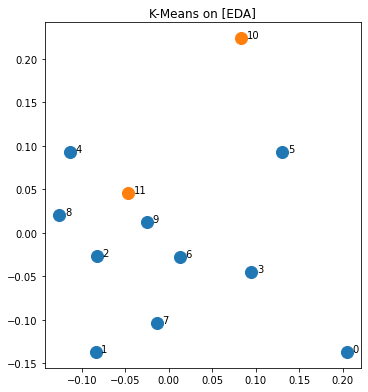

<Figure size 432x288 with 0 Axes>

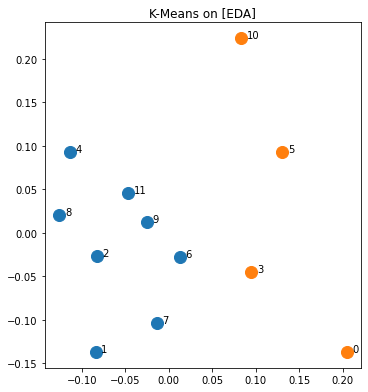

In [13]:
# Select studied classes
ISC_EDA = ISC_EDA[idxStudiedClasses,:]
ISC_EDA = ISC_EDA[:,idxStudiedClasses]

#Compute chosen clustering
method_result = Results(mat=mat,mapping=mapping,algo=algo,condition=condition)
n_clusters = nClusters*nPeriod
print(n_clusters)
print(nClusters)
dim = 2

if (algo == 'K-Means'):
    method = KMeans(n_clusters=n_clusters,n_init=100)
elif (algo == 'Spectral Clustering'):
    method = SpectralClustering(n_clusters=n_clusters,n_init=10,gamma=1)
elif (algo == 'K-Medoids'):
    method = KMedoids(n_clusters=n_clusters,tmax=1000)
elif (algo == 'Hierarchical Clustering'):
    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="ward")
    
elif (algo == 'Spectral Clustering distance'):
    method = SpectralClustering(n_clusters=n_clusters,n_init=10,gamma=1,affinity='precomputed')
elif (algo == 'Hierarchical Clustering distance'):
    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="single",affinity='precomputed')
#elif (algo == 'Hierarchical Clustering distance'): # ward doesnt work with precomputed matrix
#    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="ward",affinity='precomputed')
        
method_result.applyMethod(method)

# Show results
method_result.twoClustersMethodResult()
method_result.showResultMap()

plt.figure()
groundTruth = False
trueDisplay = False
method_result.showResultMap()

'''
from sklearn.metrics import homogeneity_score
condition = np.genfromtxt(os.path.join('conditionSchool_%s.csv' %mat[0]),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
if mat == ['EDA']:
    condition = removeSubjectsVector(condition,subjectsRemoved_EDA)
elif mat == ['IBI']:
    condition = removeSubjectsVector(condition,subjectsRemoved_IBI)
print("homogeneity")
print(homogeneity_score(condition,method_result.label))
'''

## Change dim

In [14]:
# Compute chosen clustering
method_result = Results(mat=mat,mapping=mapping,algo=algo,condition=condition)
accDim = []
allDim = np.arange(2,int(nParticipants/3))

if (algo == 'K-Means'):
    method = KMeans(n_clusters=n_clusters,n_init=100)
elif (algo == 'Spectral Clustering'):
    method = SpectralClustering(n_clusters=n_clusters,n_init=10,gamma=1)
elif (algo == 'K-Medoids'):
    method = KMedoids(n_clusters=n_clusters,tmax=1000)
elif (algo == 'Hierarchical Clustering'):
    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="ward")

for dim in allDim:
    method_result.applyMethod(method)
    accDim.append(method_result.accuracy())

71
[0 0 0 0 0 0 0 0 0 0 1 1]
[0 1 1 0 1 0 1 1 1 1 0 1]
71
[0 0 0 0 0 0 0 0 0 0 1 1]
[1 0 0 1 0 1 0 1 0 0 1 1]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


No handles with labels found to put in legend.


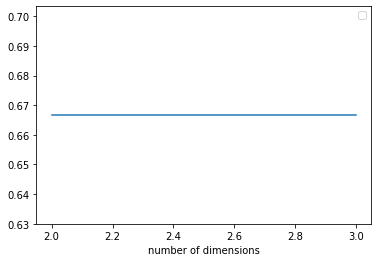

In [15]:
plt.plot(allDim,accDim)
plt.xlabel("number of dimensions")
plt.legend()